# 0. About 

This notebook is to test if the Regularized CCA estimator, i.e. `sklearn.base.BaseEstimator`, is working as expected.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings
import time
from tqdm.notebook import tqdm

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV, ParameterGrid
from sklearn.utils import Bunch, check_array
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances, pairwise_kernels

from rcca import TwoViewRCCA

from cca_zoo.models import rCCA as cz_rCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV

rs_num = 42
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

n_splits = 3
n_repeats = 20

%matplotlib inline

# 1. Dataset Construction

In [2]:
sample_num = 100
X_dimension_num = 30
Y_dimension_num = 10

# construct X
X = rng.normal(loc=0.5, scale=1.0, size=(sample_num, X_dimension_num))

# construct noise
delta_1 = rng.normal(loc=0.0, scale=0.2, size=(sample_num, ))
delta_2 = rng.normal(loc=0.0, scale=0.1, size=(sample_num, ))
delta_3 = rng.normal(loc=0.0, scale=0.1, size=(sample_num, ))

# construct Y
Y = rng.normal(loc=0.1, scale=1.0, size=(sample_num, Y_dimension_num))
Y[:, 0] = X[:, 3] + delta_1
Y[:, 1] = X[:, 0] + delta_2
Y[:, 2] = X[:, 1] + delta_3

In [3]:
# split dataset into training and testing
[X_train, X_test, Y_train, Y_test] = train_test_split(
    X, Y, test_size=0.20, random_state=rs_num
)

In [4]:
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(Y_train)
X_train = scaler_x.transform(X_train)
Y_train = scaler_y.transform(Y_train)
X_test = scaler_x.transform(X_test)
Y_test = scaler_y.transform(Y_test)

# 2. Solve RCCA through CCA-Zoo

## 2.1. Searching for Optimal Regularization Terms

In [5]:
# take means of the scores
def cz_scoring_func(estimator, views):
    return np.nanmean(estimator.score(views))

In [6]:
cz_bunch = Bunch()
cz_bunch.name = 'cz rcca'

# set up parameters
cz_bunch.n_components = 3
cz_bunch.c_x_arr = 1.818*np.logspace(-3, -2, 11)
cz_bunch.c_y_arr = 1.818*np.logspace(-4.5, -2.5, 11)
cz_bunch.param_grid = {
    'c': [cz_bunch.c_x_arr.tolist(), cz_bunch.c_y_arr.tolist()]
}

# ignore warnings for some bad searching
warnings.filterwarnings('ignore')

# searching for best parameters
cz_bunch.gscv = cz_GridSearchCV(
    cz_rCCA(
        latent_dims=cz_bunch.n_components, 
        random_state=rs_num
    ), 
    param_grid=cz_bunch.param_grid, 
    scoring=cz_scoring_func, 
    cv=RepeatedKFold(
        n_splits=n_splits, 
        n_repeats=n_repeats, 
        random_state=rs_num
    )
).fit([X_train, Y_train])

# reset warnings
warnings.resetwarnings()

## 2.2. Visualization

In [7]:
# visualization of c_x, c_y searching
def viz_cxcy_search(
    fig, ax, viz_x, viz_y, viz_color, n_repeats, n_splits, c_x_opt, c_y_opt
):
    sc = ax.scatter(
        viz_x, viz_y, c=viz_color, s=5
    )
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('Mean Test Score (Canonical Correlation)')
    ax.scatter(
        c_x_opt, 
        c_y_opt, 
        marker='o',
        ec='royalblue', 
        fc='none', 
        label='optimal'
    )

    ax.set(
        xlabel='$c_x$', 
        ylabel='$c_y$', 
        title=(
            'Grid Search with {}-repeat {}-fold CV'.format(n_repeats, n_splits) + 
            '\nfor Optimal Regularization Parameters'
        )
    )
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=1,
        fontsize='small'
    )

In [8]:
# re-arrange arrays for visualization
cz_bunch.viz_x = np.zeros((cz_bunch.gscv.cv_results_['mean_test_score'].size, ))
cz_bunch.viz_y = np.zeros_like(cz_bunch.viz_x)
cz_bunch.viz_color = cz_bunch.gscv.cv_results_['mean_test_score']
cz_bunch.c_x_opt = cz_bunch.gscv.best_params_['c'][0]
cz_bunch.c_y_opt = cz_bunch.gscv.best_params_['c'][1]

for c_list_i, c_list in enumerate(cz_bunch.gscv.cv_results_['param_estimator__c']):
    cz_bunch.viz_x[c_list_i] = c_list[0]
    cz_bunch.viz_y[c_list_i] = c_list[1]

The c_x optimal is 9.11e-03 and the c_y optimal is 5.75e-04


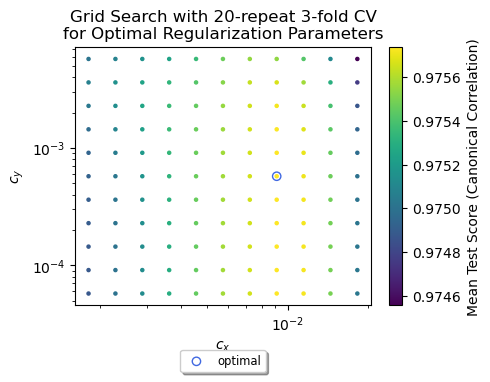

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))

viz_cxcy_search(
    fig, ax, cz_bunch.viz_x, cz_bunch.viz_y, 
    cz_bunch.viz_color, n_repeats, n_splits, 
    cz_bunch.c_x_opt, cz_bunch.c_y_opt
)

ax.set(xscale='log', yscale='log')

fig.tight_layout()

print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    cz_bunch.c_x_opt, 
    cz_bunch.c_y_opt
))

# 3. Solve RCCA through Estimator - SVD Method

In [10]:
def estimator_score_func(estimator, X, y):
    score = estimator.score(X, y)
    return np.nanmean(score)

In [11]:
estimator_svd_bunch = Bunch()
estimator_svd_bunch.name = 'Estimator RCCA SVD'

estimator_svd_bunch.n_components = 3
estimator_svd_bunch.standardization = True

# set up the parameter grid
estimator_svd_bunch.param_grid = {
    'c_x': cz_bunch.c_x_arr, 
    'c_y': cz_bunch.c_y_arr
}

# ignore warnings for some bad searching
warnings.filterwarnings('ignore')

estimator_svd_bunch.gscv = GridSearchCV(
    TwoViewRCCA(
        n_components=estimator_svd_bunch.n_components, 
        solving_method='svd', 
        random_state=rs_num, 
        standardization=estimator_svd_bunch.standardization
    ), 
    param_grid=estimator_svd_bunch.param_grid, 
    scoring=estimator_score_func, 
    cv=RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num
    ), 
    n_jobs=-1
).fit(X_train, Y_train)

# reset warnings
warnings.resetwarnings()

In [12]:
# re-arrange arrays for visualization
estimator_svd_bunch.viz_x = estimator_svd_bunch.gscv.cv_results_['param_c_x'].data
estimator_svd_bunch.viz_y = estimator_svd_bunch.gscv.cv_results_['param_c_y'].data
estimator_svd_bunch.viz_color = estimator_svd_bunch.gscv.cv_results_['mean_test_score']
estimator_svd_bunch.c_x_opt = estimator_svd_bunch.gscv.best_params_['c_x']
estimator_svd_bunch.c_y_opt = estimator_svd_bunch.gscv.best_params_['c_y']

For cca-zoo rcca:
The c_x optimal is 9.11e-03 and the c_y optimal is 5.75e-04
For estimator rcca with svd method:
The c_x optimal is 9.11e-03 and the c_y optimal is 5.75e-05


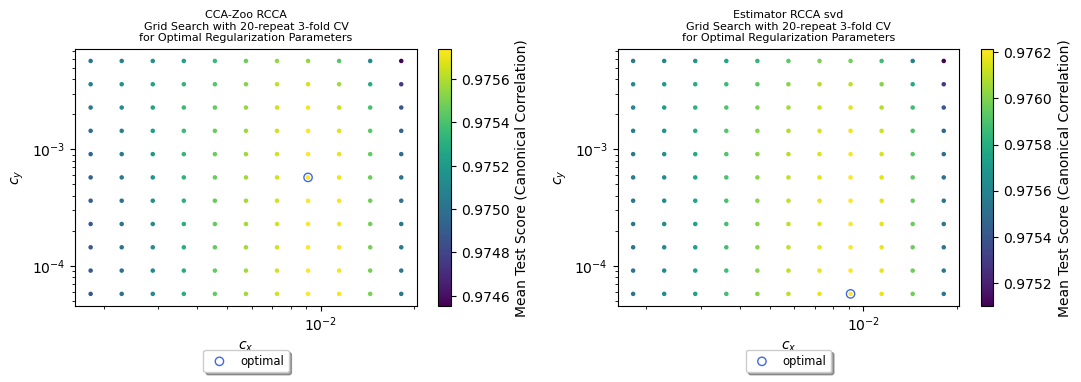

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

viz_cxcy_search(
    fig, axes[0], cz_bunch.viz_x, cz_bunch.viz_y, 
    cz_bunch.viz_color, n_repeats, n_splits, 
    cz_bunch.c_x_opt, cz_bunch.c_y_opt
)
axes[0].set_title('CCA-Zoo RCCA\n'+axes[0].title.get_text(), fontsize=8)
axes[0].set(xscale='log', yscale='log')

viz_cxcy_search(
    fig, axes[1], estimator_svd_bunch.viz_x, estimator_svd_bunch.viz_y, 
    estimator_svd_bunch.viz_color, n_repeats, n_splits, 
    estimator_svd_bunch.c_x_opt, estimator_svd_bunch.c_y_opt
)
axes[1].set_title('Estimator RCCA svd\n'+axes[1].title.get_text(), fontsize=8)
axes[1].set(xscale='log', yscale='log')

fig.tight_layout()

print('For cca-zoo rcca:')
print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    cz_bunch.c_x_opt, 
    cz_bunch.c_y_opt
))
print('For estimator rcca with svd method:')
print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    estimator_svd_bunch.c_x_opt, 
    estimator_svd_bunch.c_y_opt
))

# 4. Solve RCCA through Estimator - Generalized Eigenvalue Problem

In [14]:
estimator_gen_bunch = Bunch()
estimator_gen_bunch.name = 'Estimator RCCA Generalized Eigenvalue Problem'

estimator_gen_bunch.n_components = 3
estimator_gen_bunch.standardization = True

# set up the parameter grid
estimator_gen_bunch.param_grid = {
    'c_x': cz_bunch.c_x_arr, 
    'c_y': cz_bunch.c_y_arr
}

# ignore warnings for some bad searching
warnings.filterwarnings('ignore')

estimator_gen_bunch.gscv = GridSearchCV(
    TwoViewRCCA(
        n_components=estimator_gen_bunch.n_components, 
        solving_method='gen_eig', 
        random_state=rs_num, 
        standardization=estimator_gen_bunch.standardization
    ), 
    param_grid=estimator_gen_bunch.param_grid, 
    scoring=estimator_score_func, 
    cv=RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num
    ), 
    n_jobs=-1
).fit(X_train, Y_train)

# reset warnings
warnings.resetwarnings()

In [15]:
# re-arrange arrays for visualization
estimator_gen_bunch.viz_x = estimator_gen_bunch.gscv.cv_results_['param_c_x'].data
estimator_gen_bunch.viz_y = estimator_gen_bunch.gscv.cv_results_['param_c_y'].data
estimator_gen_bunch.viz_color = estimator_gen_bunch.gscv.cv_results_['mean_test_score']
estimator_gen_bunch.c_x_opt = estimator_gen_bunch.gscv.best_params_['c_x']
estimator_gen_bunch.c_y_opt = estimator_gen_bunch.gscv.best_params_['c_y']

For cca-zoo rcca:
The c_x optimal is 9.11e-03 and the c_y optimal is 5.75e-04
For estimator rcca with svd method:
The c_x optimal is 9.11e-03 and the c_y optimal is 5.75e-05
For estimator rcca with generalized eigenvalue problem method:
The c_x optimal is 9.11e-03 and the c_y optimal is 5.75e-05


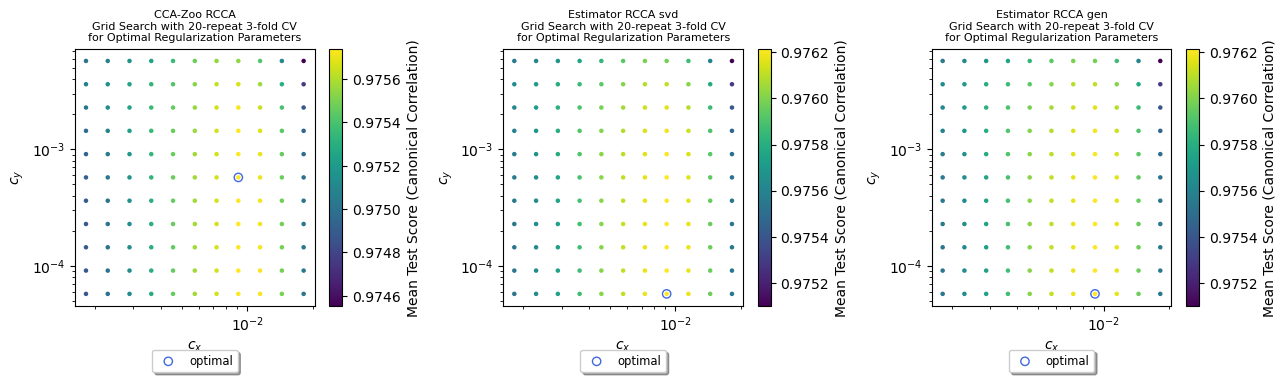

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# cca-zoo
viz_cxcy_search(
    fig, axes[0], cz_bunch.viz_x, cz_bunch.viz_y, 
    cz_bunch.viz_color, n_repeats, n_splits, 
    cz_bunch.c_x_opt, cz_bunch.c_y_opt
)
axes[0].set_title('CCA-Zoo RCCA\n'+axes[0].title.get_text(), fontsize=8)
axes[0].set(xscale='log', yscale='log')

# estimator - svd
viz_cxcy_search(
    fig, axes[1], estimator_svd_bunch.viz_x, estimator_svd_bunch.viz_y, 
    estimator_svd_bunch.viz_color, n_repeats, n_splits, 
    estimator_svd_bunch.c_x_opt, estimator_svd_bunch.c_y_opt
)
axes[1].set_title('Estimator RCCA svd\n'+axes[1].title.get_text(), fontsize=8)
axes[1].set(xscale='log', yscale='log')

# estimator - generalized eigenvalue problem
viz_cxcy_search(
    fig, axes[2], estimator_gen_bunch.viz_x, estimator_gen_bunch.viz_y, 
    estimator_gen_bunch.viz_color, n_repeats, n_splits, 
    estimator_gen_bunch.c_x_opt, estimator_gen_bunch.c_y_opt
)
axes[2].set_title('Estimator RCCA gen\n'+axes[2].title.get_text(), fontsize=8)
axes[2].set(xscale='log', yscale='log')

fig.tight_layout()

print('For cca-zoo rcca:')
print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    cz_bunch.c_x_opt, 
    cz_bunch.c_y_opt
))
print('For estimator rcca with svd method:')
print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    estimator_svd_bunch.c_x_opt, 
    estimator_svd_bunch.c_y_opt
))
print('For estimator rcca with generalized eigenvalue problem method:')
print('The c_x optimal is {:.2e} and the c_y optimal is {:.2e}'.format(
    estimator_gen_bunch.c_x_opt, 
    estimator_gen_bunch.c_y_opt
))

# 5. Canonical Correlation Comparison

In [17]:
# compute canonical correlation for cca-zoo
cz_bunch.cca = cz_bunch.gscv.best_estimator_.fit([X_train, Y_train])
[Xc_train, Yc_train] = cz_bunch.cca.transform([X_train, Y_train])
cz_bunch.cc_arr_train = np.diag(
    cosine_similarity(Xc_train.T, Yc_train.T)
)
[Xc_test, Yc_test] = cz_bunch.cca.transform([X_test, Y_test])
cz_bunch.cc_arr_test = np.diag(
    cosine_similarity(Xc_test.T, Yc_test.T)
)

# compute canonical correlation for estimator svd
estimator_svd_bunch.cca = estimator_svd_bunch.gscv.best_estimator_.fit(X_train, Y_train)
[Xc_train, Yc_train] = estimator_svd_bunch.cca.transform(X_train, Y_train)
estimator_svd_bunch.cc_arr_train = np.diag(
    cosine_similarity(Xc_train.T, Yc_train.T)
)
[Xc_test, Yc_test] = estimator_svd_bunch.cca.transform(X_test, Y_test)
estimator_svd_bunch.cc_arr_test = np.diag(
    cosine_similarity(Xc_test.T, Yc_test.T)
)

# compute canonical correlation for estimator generalized eigenvalue problem
estimator_gen_bunch.cca = estimator_gen_bunch.gscv.best_estimator_.fit(X_train, Y_train)
[Xc_train, Yc_train] = estimator_gen_bunch.cca.transform(X_train, Y_train)
estimator_gen_bunch.cc_arr_train = np.diag(
    cosine_similarity(Xc_train.T, Yc_train.T)
)
[Xc_test, Yc_test] = estimator_gen_bunch.cca.transform(X_test, Y_test)
estimator_gen_bunch.cc_arr_test = np.diag(
    cosine_similarity(Xc_test.T, Yc_test.T)
)

In [18]:
print('The canonical correlation for CCA-Zoo RCCA:')
print('on training datasets:')
print(cz_bunch.cc_arr_train)
print('on test datasets:')
print(cz_bunch.cc_arr_test)

print()
print('The canonical correlation for Estimator RCCA through svd:')
print('on training datasets:')
print(estimator_svd_bunch.cc_arr_train)
print('on test datasets:')
print(estimator_svd_bunch.cc_arr_test)

print()
print('The canonical correlation for Estimator RCCA through gen-eig:')
print('on training datasets:')
print(estimator_gen_bunch.cc_arr_train)
print('on test datasets:')
print(estimator_gen_bunch.cc_arr_test)

The canonical correlation for CCA-Zoo RCCA:
on training datasets:
[0.99805583 0.99775681 0.99107825]
on test datasets:
[0.98732226 0.98994962 0.98296484]

The canonical correlation for Estimator RCCA through svd:
on training datasets:
[0.99806524 0.9977607  0.99107113]
on test datasets:
[0.98738213 0.98985877 0.98288935]

The canonical correlation for Estimator RCCA through gen-eig:
on training datasets:
[0.99806524 0.9977607  0.99107113]
on test datasets:
[0.98738213 0.98985877 0.98288935]


Everything looks good!